# Отчёт по лабораторной работе №8 "Выявление аномалий"

In [1]:
import numpy as np
from matplotlib import cm
import scipy.stats as stats
import matplotlib.pyplot as plt
np.seterr(divide='ignore', invalid='ignore')

DATA_FILE_NAME_1 = 'Lab 8/ex8data1'
DATA_FILE_NAME_2 = 'Lab 8/ex8data2'

Imports from 'common' file:

In [3]:
import os
from scipy.io import loadmat

DATA_DIRECTORY = '../Data/'


def load_data_from_mat_file(filename, directory=DATA_DIRECTORY):
    filepath = directory + f'{filename}.mat'
    return loadmat(filepath)

### 1. Загрузите данные ​ ex8data1.mat ​ из файла.

In [6]:
df_data = load_data_from_mat_file(DATA_FILE_NAME_1)
X = df_data['X']
Xval = df_data['Xval']
Yval = df_data['yval']

### 2. Постройте график загруженных данных в виде диаграммы рассеяния.

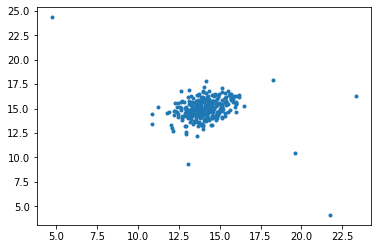

In [5]:
plt.scatter(X[:, 0], X[:, 1], marker='.')
plt.show()

### 3. Представьте данные в виде двух независимых нормально распределенных случайных величин.

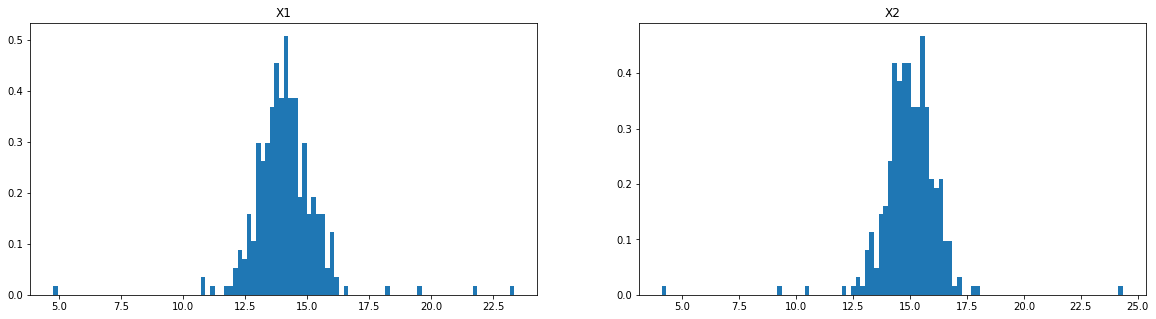

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].hist(X[:, 0], 100, density=True)
axs[0].set_title('X1')
axs[1].hist(X[:, 1], 100, density=True)
axs[1].set_title('X2')
plt.show()

### 4. Оцените параметры распределений случайных величин.

In [11]:
def get_dist_params(X):
    return X.mean(axis=0), X.std(axis=0)


Mu, Sigma = get_dist_params(X)
print('Mean:', Mu)
print('Sigma:', Sigma, '\n')

Mean: [14.11222578 14.99771051]
Sigma: [1.35374717 1.3075723 ] 



### 5. Постройте график плотности распределения получившейся случайной величины в виде изолиний, совместив его с графиком из пункта 2.

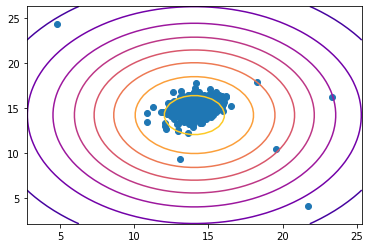

In [12]:
def p(X, Mu=None, Sigma=None):
    Mu, Sigma = get_dist_params(X) if Mu is None and Sigma is None else (Mu, Sigma)
    axis = int(len(X.shape) > 1)
    return stats.norm.pdf(X, Mu, Sigma).prod(axis=axis)


h = 2.
x = np.linspace(X[:, 0].min() - h, X[:, 0].max() + h, 50)
y = np.linspace(X[:, 1].min() - h, X[:, 1].max() + h, 50)
xx, yy = np.meshgrid(x, y)
Xnew = np.column_stack((xx.flatten(), yy.flatten()))
Z = p(Xnew).reshape((len(xx), len(yy)))
plt.contour(xx, yy, Z, cmap=cm.plasma)
plt.scatter(X[:, 0], X[:, 1], marker='o')
plt.show()

### 6. Подберите значение порога для обнаружения аномалий на основе валидационной выборки. В качестве метрики используйте F1-меру.

In [13]:
def f1_score(true_positive, false_positive, false_negative):
    try:
        precision = true_positive / (true_positive + false_positive)
        recall = true_positive / (true_positive + false_negative)
        return 2 * precision * recall / (precision + recall)
    except ZeroDivisionError:
        return 0


def get_check_params_function(X, Xval, Y, prop_function=p, dist_params_function=get_dist_params):
    Mu, Sigma = dist_params_function(X)
    props = prop_function(Xval, Mu=Mu, Sigma=Sigma)

    def func(eps):
        indexes = np.argwhere(props < eps)
        true_positive = Y[indexes].sum()
        false_positive = int(len(indexes) - true_positive)

        indexes = np.argwhere(props >= eps)
        false_negative = Y[indexes].sum()
        return f1_score(true_positive, false_positive, false_negative)

    return func


def get_optimal_eps(X, Xval, Yval, eps_list=None, prop_function=p, dist_params_function=get_dist_params):
    best_eps = 0
    max_score = -np.inf
    eps_list = np.arange(0, 0.4, 1e-2) if eps_list is None else eps_list
    check_params_function = get_check_params_function(
        X, Xval, Yval, prop_function=prop_function, dist_params_function=dist_params_function)

    for eps in eps_list:
        metric = check_params_function(eps)
        if metric >= max_score:
            max_score = metric
            best_eps = eps

    print('Best eps:', best_eps)
    print('F1 score:', max_score, '\n')
    return best_eps


best_eps = get_optimal_eps(X, Xval, Yval, eps_list=np.arange(0, 0.4, 1e-4))

Best eps: 0.0004
F1 score: 0.8750000000000001 



### 7. Выделите аномальные наблюдения на графике из пункта 5 с учетом выбранного порогового значения.

Number of anomalies: 6



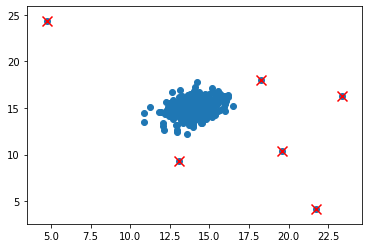

In [15]:
X_props = p(X)
indexes = np.argwhere(X_props < best_eps)
anomalies = X[indexes.flatten()]
print(f'Number of anomalies: {anomalies.shape[0]}\n')
plt.scatter(X[:, 0], X[:, 1], marker='o')
plt.scatter(anomalies[:, 0], anomalies[:, 1], c='r', marker='x', s=100)
plt.show()

### 8. Загрузите данные ​ ex8data2.mat ​ из файла.

In [17]:
df_data = load_data_from_mat_file(DATA_FILE_NAME_2)
X = df_data['X']
Xval = df_data['Xval']
Yval = df_data['yval']

### 9. Представьте данные в виде 11-мерной нормально распределенной случайной величины.

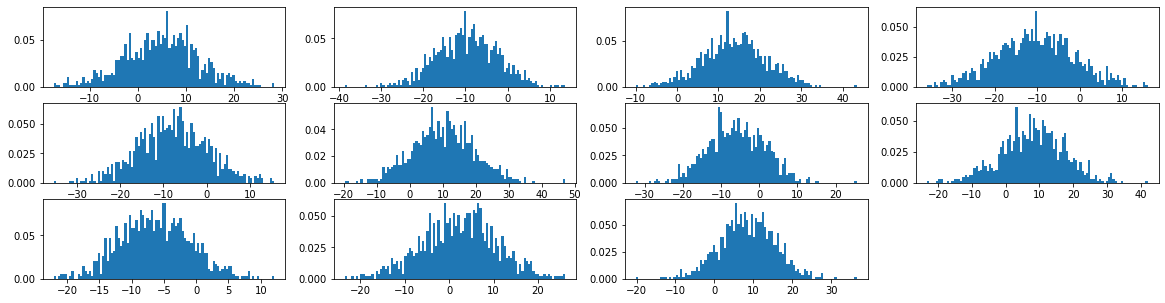

In [18]:
size = int(np.sqrt(X.shape[1]))

fig, axs = plt.subplots(size, size + 1, figsize=(20, 5))
axs = axs.flatten()
[fig.delaxes(ax) for ax in axs[X.shape[1]:]]

for i in range(X.shape[1]):
    axs[i].hist(X[:, i], 100, density=True)

plt.show()


### 10.Оцените параметры распределения случайной величины.

In [19]:
def get_multivariate_dist_params(X):
    Mu, Sigma_v = get_dist_params(X)
    Sigma_m = np.zeros((len(Sigma_v), len(Sigma_v)))
    np.fill_diagonal(Sigma_m, Sigma_v)
    return Mu, Sigma_m


Mu, Sigma = get_multivariate_dist_params(X)
print('Mean:', Mu)
print('Sigma shape:', Sigma.shape, '\n')

Mean: [  4.93940034  -9.63726819  13.81470749 -10.4644888   -7.95622922
  10.19950372  -6.01940755   7.96982896  -6.2531819    2.32451289
   8.47372252]
Sigma shape: (11, 11) 



### 11.Подберите значение порога для обнаружения аномалий на основе валидационной выборки. В качестве метрики используйте F1-меру.

In [20]:
def multivariate_p(X, Mu=None, Sigma=None):
    Mu, Sigma = get_multivariate_dist_params(X) if Mu is None and Sigma is None else (Mu, Sigma)
    return stats.multivariate_normal.pdf(X, Mu, Sigma)


X_props = multivariate_p(X)

min_rank = -int(np.log10(X_props.min()))
eps_list = [10 ** (-min_rank + i) for i in range(min_rank)]
best_eps = get_optimal_eps(X, Xval, Yval,
                           eps_list=eps_list,
                           prop_function=multivariate_p,
                           dist_params_function=get_multivariate_dist_params)


Best eps: 1e-55
F1 score: 0.7499999999999999 



### 12.Выделите аномальные наблюдения в обучающей выборке. Сколько их было обнаружено? Какой был подобран порог?

In [23]:
indexes = np.argwhere(X_props < best_eps)
anomalies = X[indexes.flatten()]
print(f'Number of anomalies: {anomalies.shape[0]}')
print(f'Epsilon with max F1 score: {best_eps}')

Number of anomalies: 13
Epsilon with max F1 score: 1e-55
